In [217]:
import pandas as pd
import requests
import numpy as np
import glob
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
date_today = datetime.date.today().isoformat()

# Extract Indicator IDs per indicator

In [102]:
analytics_export = glob.glob('*.csv')[0]
top_25 = pd.read_csv(analytics_export, skiprows=6, nrows=25)
top_25['Indicator ID'] = 0

In [103]:
pattern = 'var indicatorID = \"(\d+)\";'

for ix in range(len(top_25['Page'])):
    url_ind = top_25.ix[ix, 'Page']
    r = requests.get('https://tcdata360.worldbank.org' + url_ind)
    m = re.search(pattern,r.text)
    try:
        ind_id = int(m.group(1))
        top_25.ix[ix, 'Indicator ID'] = ind_id
    except:
        continue

C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [111]:
top_25.ix[2,'Indicator ID'] = 669
top_25.ix[24,'Indicator ID'] = 669
top_25.ix[18,'Indicator ID'] = 277

In [117]:
top_25.to_csv("%s - Top 25 indicators.csv" % date_today)

# Extract data for single indicator

In [243]:
ind_ix = 3

In [244]:
ind_id_get = top_25.ix[ind_ix, 'Indicator ID']
print(top_25.ix[ind_ix, 'Page'], ind_id_get)
url_data = 'https://tcdata360-backend.worldbank.org/api/v1/data?indicators=%d' % ind_id_get
r = requests.get(url_data)

for ix in range(len(r.json()['data'])):
    
    df_temp = pd.DataFrame.from_dict(r.json()['data'][ix]['indicators'][0]['values'], orient='index')
    df_temp.columns = [r.json()['data'][ix]['id']]
    if ix == 0:
        df_all = df_temp
    else:
        df_all = df_all.join(df_temp)

df_all = df_all.T

/indicators/hh.mkt 2370


In [245]:
df_all_melt = pd.melt(df_all.reset_index(), value_vars=df_all.columns, id_vars=['index'])

# Try visualizations

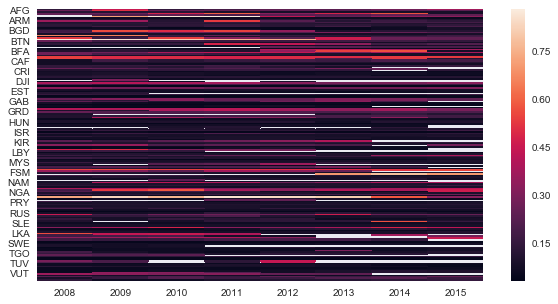

In [246]:
sns.heatmap(df_all)

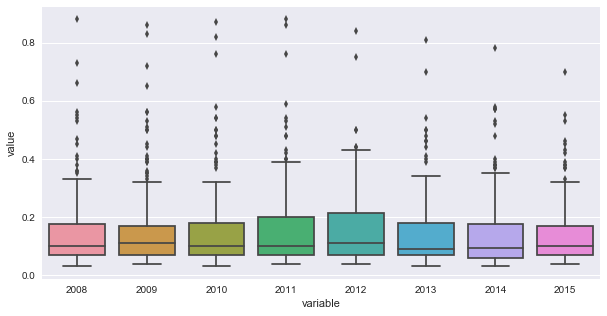

In [247]:
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(x="variable", y="value", data=df_all_melt)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002487B40C1D0>,
      dtype=object)

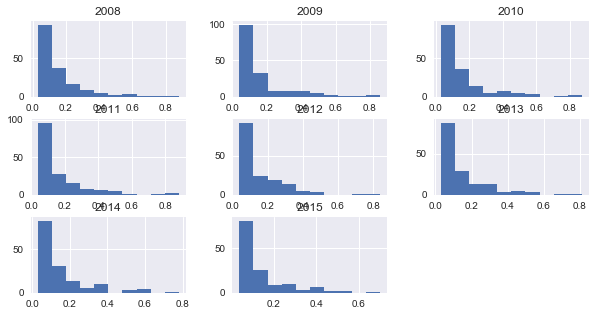

In [248]:
df_all.hist()

# Try outlier detection on dataframe

In [249]:
df = df_all_melt.copy()
df.columns = ['G1', 'G2', 'Value']
stds = 1.0
outliers = df[['G1', 'G2', 'Value']].groupby(['G1','G2']).transform(
           lambda group: (group - group.mean()).abs().div(group.std())) > stds

dfo = df[outliers.Value == True]
dfo

,G1,G2,Value
